![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

This material was created after a journal club in our group by Christian Silbermann and Thomas Nagel.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics

In [26]:
import matplotlib.pyplot as plt
import numpy as np

#Some plot settings
import plot_functions.plot_settings

# Connection between capillary rise, pressure and saturation profiles in soils

Deriving the flow law's from thermodynamic principles leads to the following two equations (see Ehlers and Wagner, 2019; Grunwald et al., 2020; others)

\begin{align*}
    \tilde{\mathbf{w}}_\text{GS} &= - \frac{k_\text{rel,G} \mathbf{k}}{\mu_\text{GR}} \left( \text{grad}\,p_\text{GR} - \varrho_\text{GR} \mathbf{b} \right)
    \\
    \tilde{\mathbf{w}}_\text{LS} &= - \frac{k_\text{rel,L} \mathbf{k}}{\mu_\text{LR}} \left( \text{grad}\,p_\text{LR} - \varrho_\text{LR} \mathbf{b} - \frac{p_\text{cap}}{S_\text{L}} \text{grad}\,S_\text{L} \right)
\end{align*}

The second term is rarely seen. Here we investigate its physical meaning. For that purpose, we look at the equlibrium distribution of liquid pressure and saturation above a groundwater table for different retention properties. The hypothesis is that the final term leads to a coupling between the pressure and saturation profiles in soils especially for strongly capillary active media.

Our assumptions are:
* Richards approximation: $p_\text{GR} = 0 = \text{const.}$, $p_\text{cap} = - p_\text{LR}$
* Equilibrium: $\tilde{\mathbf{w}}_\text{LS} = 0$
* One-dimensional problem, $z$ points upward and starts at the groundwater table, so that $b=-g$

Hence, we arrive at:

\begin{align*}
    0 &= \text{grad}\,p_\text{LR} + \varrho_\text{LR} g - \frac{p_\text{cap}}{S_\text{L}} \text{grad}\,S_\text{L}
    \\
    \frac{\partial p_\text{LR}}{\partial z} &= -\varrho_\text{LR} g + \frac{p_\text{LR}}{S_\text{L}} \frac{\partial S_\text{L}}{\partial z}
\end{align*}

We use a van Genuchten model:

$$
    S_\text{L}= \left[ 1 + \left( \frac{p_\text{cap}}{a} \right)^b \right]^{-c}
$$

For which we require the derivative:

$$
    \frac{\partial S_\text{L}}{\partial p_\text{cap}} = - \frac{cb}{a} \left[1 + \left( \frac{p_\text{cap}}{a} \right)^b \right]^{-c-1} \left( \frac{p_\text{cap}}{a} \right)^{b-1}
$$

We arrive at the following pressure gradient:

$$
    \frac{\partial p_\text{LR}}{\partial z} = -\frac{\gamma_\text{LR}}{1 - \displaystyle\frac{\partial S_\text{L}}{\partial p_\text{cap}} \frac{p_\text{LR}}{S_\text{L}}}
$$

At the groundwater table we set

$$
    p_\text{LR} |_{z=0} = 0
$$

In [27]:
def saturation(pcap,b=1.5,a=5e4):
    c = (1-1/b)
    return 1/np.power(1+np.power(pcap/a,b),c)

def dSat_dpcap(pcap,b=1.5,a=5e4):
    c = (1-1/b)
    term1 = np.power(pcap/a,b-1)
    term12 = 1.+np.power(pcap/a,b)
    term2 = np.power(term12,-c-1)
    return -c*b/a * term1 * term2

In [28]:
def plot_input(b):
    pc=np.logspace(-2,10,1000)
    fig, ax = plt.subplots(ncols=2,figsize=(18,8))

    for i in b:
        ax[0].plot(saturation(pc,i),pc,label=str(i))
        ax[1].plot(saturation(pc,i),-dSat_dpcap(pc,i))
    ax[0].set_yscale('log')
    ax[0].set_xlabel('$S_\\mathrm{L}$')
    ax[0].set_ylabel('$p_\\mathrm{cap}$ / Pa')

    
    ax[1].set_yscale('log')
    ax[1].set_xlabel('$S_\\mathrm{L}$')
    ax[1].set_ylabel('$(\\partial S_\\mathrm{L} / \\partial p_\\mathrm{cap})$ / Pa$^{-1}$')
    fig.legend()
    fig.tight_layout();

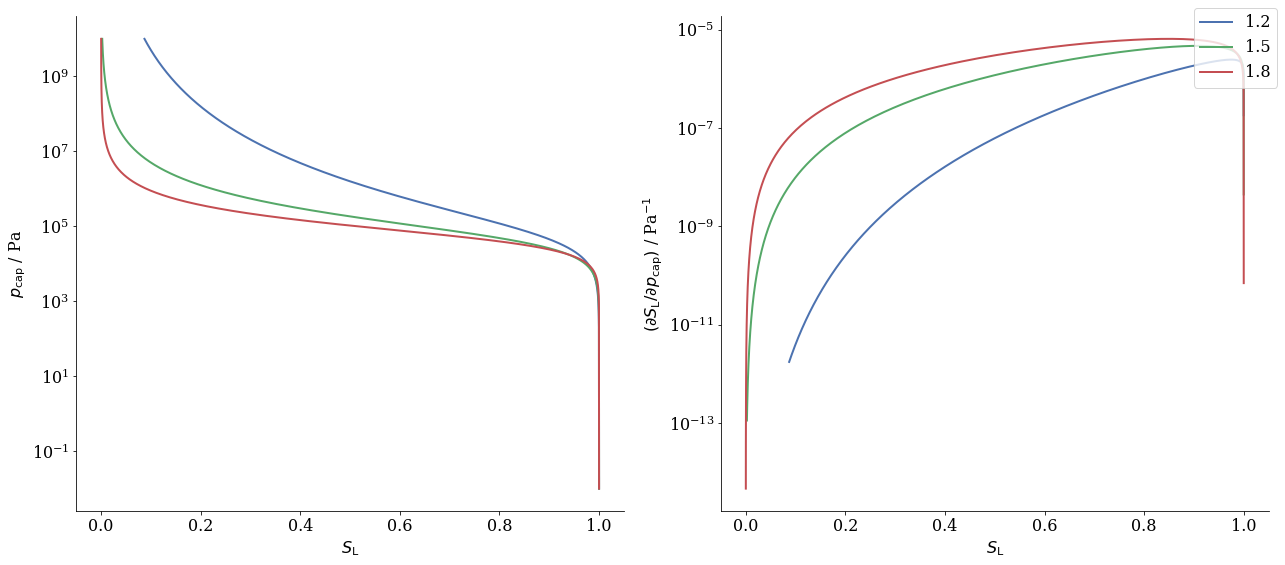

In [29]:
plot_input([1.2, 1.5, 1.8])

In [30]:
epsilon = lambda p: p/1e8

In [31]:
dsat_dp = lambda p0: (saturation(p0 + epsilon(p0)) - saturation(p0 - epsilon(p0)))/(2.*epsilon(p0))

In [32]:
rel_err = lambda p : (dsat_dp(p) - dSat_dpcap(p))/dSat_dpcap(p)

In [33]:
#plt.plot(pc,rel_err(pc))
#plt.title('relative error analytical derivative');

Now we use forward finite differences to integrate up the equation.

$$
    \frac{\partial p_\text{LR}}{\partial z} = -\frac{\gamma_\text{LR}}{1 - \displaystyle\frac{\partial S_\text{L}}{\partial p_\text{cap}} \frac{p_\text{LR}}{S_\text{L}}}
$$

We end up with the following explicit update:

$$
    p_\text{LR}(z+\Delta z) \approx p_\text{LR}(z) -\Delta z \frac{\gamma_\text{LR}}{1 - \displaystyle \left. \frac{\partial S_\text{L}}{\partial p_\text{cap}}\right|_z \frac{p_\text{LR}(z)}{S_\text{L}(-p_\text{LR}(z))}}
$$

In [34]:
def Forward_Euler_Update(pLR,dz,b,extension=1):#extension can switch off new term
    gamma_LR = 1000.*9.81
    function = gamma_LR/(1-extension*dSat_dpcap(-pLR,b) * pLR/saturation(-pLR,b))
    return - dz * function

In [35]:
def integrate(b):
    z = np.linspace(0,10,10000)
    liquid_pressure_classic = np.array([-1.e-3])
    liquid_pressure_thermo = np.array([-1.e-3])
    for i in range(1,len(z)):
        update_classic = liquid_pressure_classic[i-1] + Forward_Euler_Update(liquid_pressure_classic[i-1],z[i]-z[i-1],b,0)
        update_thermo = liquid_pressure_thermo[i-1] + Forward_Euler_Update(liquid_pressure_thermo[i-1],z[i]-z[i-1],b,1)
        liquid_pressure_classic = np.append(liquid_pressure_classic,update_classic)
        liquid_pressure_thermo = np.append(liquid_pressure_thermo,update_thermo)
    return liquid_pressure_classic,liquid_pressure_thermo,z

In [36]:
def plot_results(b):
    fig, ax = plt.subplots(ncols=2,figsize=(18,8))
    for i in b:
        liquid_pressure_classic, liquid_pressure_thermo,z = integrate(i)
        ax[0].plot(liquid_pressure_classic,z,label='classic b = %.2f' %i)
        ax[0].plot(liquid_pressure_thermo,z,label='thermo b = %.2f' %i)
        ax[1].plot(saturation(-liquid_pressure_classic),z)
        ax[1].plot(saturation(-liquid_pressure_thermo),z)
        
    ax[0].set_xlabel('$p_\\mathrm{LR}$ / Pa')
    ax[0].set_ylabel('$z$ / m')

    ax[1].set_xlabel('$S_\\mathrm{L}$')
    ax[1].set_ylabel('$z$ / m')
    fig.legend()
    fig.tight_layout();

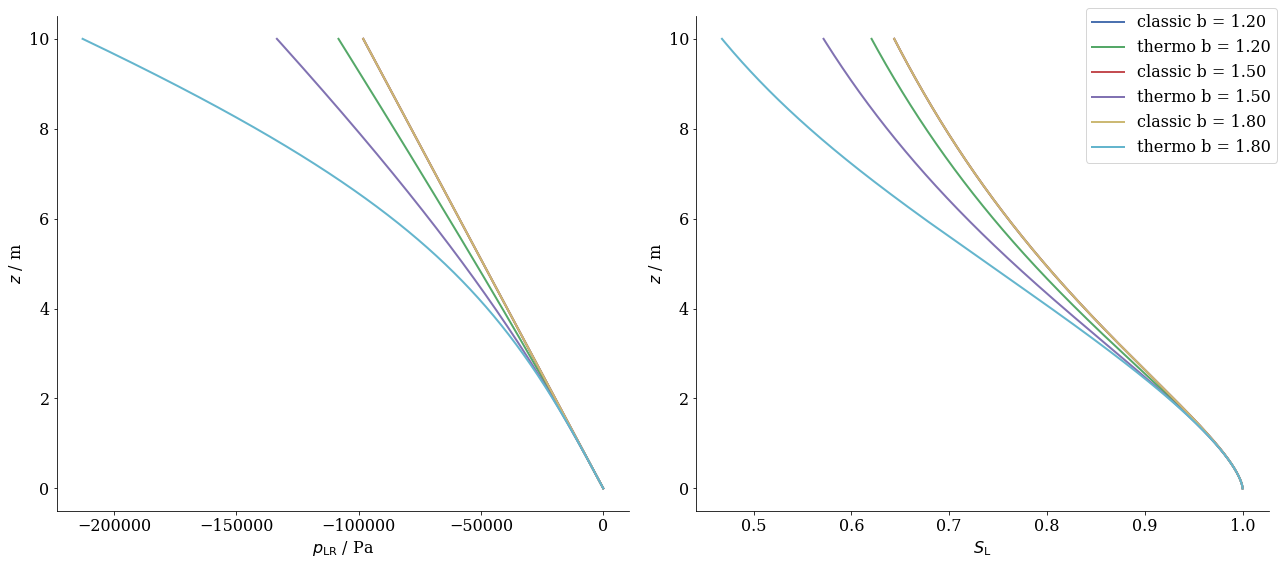

In [37]:
plot_results([1.2, 1.5, 1.8])

## Interpretation:

* All classic curves yield the same linear pressure profile peaking at 1 atm of capillary pressure.
* The extended model predicts higher capillary pressures and a non-linear profile.
* The profiles begin to diverge in the unsaturated regime (once air entry pressures are exceeded).
* The smaller the retention capacity (i.e. the shallower the $p_\text{cap}-S_\text{L}$ curve), the lower the saturation in the upper soil layer, and the larger the influence of the new term.
* The predicted saturation profiles are also lower because they are fed higher capillary pressures.
* Thus, the extended term leads to a coupling of the $p_\text{cap}-S_\text{L}$ profiles in the soil layer. In the classical model, the capillary pressure profile is independent of the retention curve, while with the extended model there is now a dependency.

### Is this real? This should be tested experimentally!